## Import Flatland

In [3]:
import flatland
flatland.__version__

'3.0.15'

In [4]:
import numpy as np
import PIL
import time
from io import BytesIO
from enum import IntEnum
from typing import List, NamedTuple, Optional, Dict, Tuple
# matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from typing import NamedTuple, Tuple, List

import networkx as nx
from IPython.display import HTML, display, clear_output
import ipywidgets as ipw
from ipycanvas import canvas


from flatland.core.grid.rail_env_grid import RailEnvTransitions
from flatland.core.transition_map import GridTransitionMap

from flatland.envs.observations import GlobalObsForRailEnv, TreeObsForRailEnv
from flatland.envs.rail_env import RailEnv, RailEnvActions
from flatland.envs.agent_utils import Agent, EnvAgent
from flatland.envs.step_utils.state_machine import TrainStateMachine
from flatland.envs.step_utils.states import TrainState
from flatland.envs.step_utils.transition_utils import check_action_on_agent
from flatland.envs.rail_generators import rail_from_grid_transition_map
from flatland.envs.rail_generators import rail_from_manual_specifications_generator

from flatland.utils.simple_rail import make_simple_rail, make_simple_rail2, make_simple_rail_with_alternatives, make_oval_rail # careful, this is not a rail environment, just a grid transition map...
#from flatland.utils.env_edit_utils import makeEnv # broken, does not work in flatland V3...
from flatland.utils.rendertools import RenderTool, AgentRenderVariant
from flatland.core.env_observation_builder import DummyObservationBuilder
from flatland.envs.line_generators import sparse_line_generator

## Create simple environment

In [7]:
def make_straight_rail(length:int=5) -> Tuple[GridTransitionMap, np.array]:
    """
    input: length. Length of straight rail line (=width of environment)
    rail looks roughly like this: (with dead ends on both sides)
    _ _ _ _ _ _ _ _ _ _

    """

    transitions = RailEnvTransitions()
    cells = transitions.transition_list

    empty = cells[0]
    dead_end_from_south = cells[7]
    vertical_straight = cells[1]
    horizontal_straight = transitions.rotate_transition(vertical_straight, 90)
    dead_end_from_east = transitions.rotate_transition(dead_end_from_south, 270)
    dead_end_from_west = transitions.rotate_transition(dead_end_from_south, 90)

    rail_map = np.array(
        [[empty] * length]+
        [[dead_end_from_east] + [horizontal_straight] * (length-2)  + [dead_end_from_west]]+
        [[empty] * length], dtype=np.uint16)

    rail = GridTransitionMap(width=rail_map.shape[1],
                             height=rail_map.shape[0], transitions=transitions)
    rail.grid = rail_map
    city_positions = [(1,0), (1, 4)]
    train_stations = [
                      [( (0, 0), 1 ) ],
                      [( (1, length-1), 3 ) ],
                     ]

    city_orientations = [1, 3] # 0: north, 1:east, 2:south, 3:west
    agents_hints = {'city_positions': city_positions,
                    'train_stations': train_stations,
                    'city_orientations': city_orientations
                   }
    optionals = {'agents_hints': agents_hints}
    return rail, rail_map, optionals


def create_straight_rail_env(length:int=5) -> RailEnv:
    rail_straight, rail_map_straight, optionals_straight = make_straight_rail(length)
    rail_gen_straight = rail_from_grid_transition_map(rail_map=rail_straight, optionals=optionals_straight)

    straight_env = RailEnv(width=rail_straight.width, height=rail_straight.height, rail_generator=rail_gen_straight, number_of_agents=1, obs_builder_object=TreeObsForRailEnv(max_depth=0))
    straight_env.reset(regenerate_rail=False, regenerate_schedule=False, random_seed=42) # careful, some random seeds may create invalid env! (e.g. 0)
    #deactivate_windows(straight_env)
    straight_env.agents[0].initial_direction = 1
    straight_env.agents[0].initial_position = (1, 1)
    #straight_env._max_episode_steps = 10 # this was lacking
    straight_env._max_episode_steps = length * 2 # TODO...
    return straight_env

In [9]:
straight_env = create_straight_rail_env(length=5)
obs, info = straight_env.reset(regenerate_rail=False, regenerate_schedule=False, random_seed=0)

?????
0 0
?????
0 0


<br><br><br><br><br>

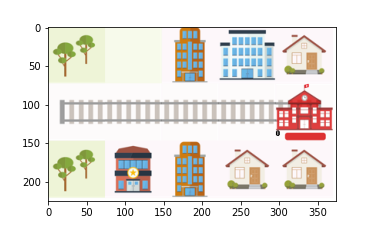

In [38]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "/Users/ryanmurphy/Documents/GitHub/flatland/individual_module/img/"
Image(filename = PATH + "simple_env.png", width=600)

## Specific elements
What pieces of information can we actually obtain?

### What the envrionment looks like

In [82]:
straight_env

In [10]:
straight_env.rail.grid

array([[   0,    0,    0,    0,    0],
       [   4, 1025, 1025, 1025,  256],
       [   0,    0,    0,    0,    0]], dtype=uint16)

In [12]:
track_env = straight_env.rail.grid

In [22]:
num_rows = len(track_env)
num_cols = len(track_env[0])
num_track = np.sum(straight_env.rail.grid != 0)

print("This environment has {} rows, {} columns, and {} cells with track.".format(num_rows, num_cols, num_track))

This environment has 3 rows, 5 columns, and 5 cells with track.


### Where the agents are

In [77]:
#direction codes
dirs = {0:'n', 1:'e', 2:'s', 3:'w'}

In [78]:
agent_location = straight_env.agents[0].initial_position
agent_direction = straight_env.agents[0].initial_direction

print("The agent is starting at {} and is facing {}.".format(agent_location, dirs[agent_direction]))

The agent is starting at (1, 1) and is facing e.


## Transforming this into ASP

In [79]:
mapping = {
     0: (0,0),
 32800: (1,0),
  1025: (1,90),
 37408: (2,0),
 17411: (2,90),
 32872: (2,180),
  3089: (2,270),
 33825: (3,0),
 38433: (4,0),
 50211: (4,90),
 99999: (4,180), # change
 35889: (4,270),
 38505: (5,0),
 52275: (5,90),
 20994: (6,0),
 16458: (6,90),
  2136: (6,180),
  6672: (6,270),
  8192: (7,0),
     4: (7,90),
   128: (7,180),
   256: (7,270),
  4608: (8,0),
 16386: (8,90),
    72: (8,180),
  2064: (8,270),
 49186: (9,0),
  1097: (9,90),
 34864: (9,180),
  5633: (9,270)
}

In [80]:
def transform_to_ASP(envir):
    """
    takes a Flatland rail environment and converts it to ASP facts
    """
    grid = envir.rail.grid
    
    # find size of grid
    num_rows = len(grid)
    num_cols = len(grid[0])
    
    # build out environment facts - ex: cell((10,5), (1,90)).
    facts = ''
    for row in range(0,num_rows):
        for col in range(0,num_cols):
            track_id = grid[row][col]
            facts += "cell({},{}), {}. \n".format(row,col,mapping[track_id]) 
            
    # include agent information
    agent_location = envir.agents[0].initial_position
    agent_direction = envir.agents[0].initial_direction
    facts += "start(cell({}), dir({})).".format(agent_location, dirs[agent_direction])
            
    return facts   
    

In [81]:
print(transform_to_ASP(straight_env))

cell(0,0), (0, 0). 
cell(0,1), (0, 0). 
cell(0,2), (0, 0). 
cell(0,3), (0, 0). 
cell(0,4), (0, 0). 
cell(1,0), (7, 90). 
cell(1,1), (1, 90). 
cell(1,2), (1, 90). 
cell(1,3), (1, 90). 
cell(1,4), (7, 270). 
cell(2,0), (0, 0). 
cell(2,1), (0, 0). 
cell(2,2), (0, 0). 
cell(2,3), (0, 0). 
cell(2,4), (0, 0). 
start(cell((1, 1)), dir(e)).
